# Quantum computation in (1+1)D scalar field theory

Let's start by doing some non-Qiskit calculations.

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg
from itertools import product
import gmpy2

In [2]:
class Lattice:
    """ Lattice class. Holds relevant information about the qubit lattice
        we want to use. Certain helper quantites are initialized to useful
        default values but can be reset if desired.
        
        In particular, field digitization is set for optimum performance
        assuming a free scalar field theory, which
    """
    
    def __init__(self, nL, nQ, dx=1, twist=0):
        """ Construct a physical lattice with nL sites of nQ qubits each.
            Lattice spacing and twist (in units of pi) can be provided.
        """
        self.dx, self.twist = dx, twist
        self.nL, self.nQ = nL, nQ
        
        # self.phiMax = np.sqrt(1/self.AvgEModes() * np.pi/2 * (self.nPhi() - 1)**2/self.nPhi())
        # Not needed since nQ setter now handles this every time nQ is changed
    
    @property
    def nQ(self):
        return self._nQ
    
    @nQ.setter
    def nQ(self, value):
        self._nQ = value
        self.phiMax = np.sqrt(1/self.AvgEModes() * np.pi/2 * (self.nPhi() - 1)**2/self.nPhi())
    
    def __repr__(self):
        ''' Print out constructor for state. '''
        return 'Lattice(nL={}, nQ={}, dx={}, twist={})'.format(self.nL, self.nQ, self.dx, self.twist)
        
    def __str__(self):
        """ Print out a basic description of the lattice. """
        return "{}-site lattice with {} qubits/site. \nlattice spacing: a = {}, boundary phase shift: theta = {:.2f}".format(nL, nQ, dx, self.theta())

    def theta(self):
        return np.pi*self.twist

    def nPhi(self):
        return 2**self.nQ
    
    def EModes(self):
        """ A helper function to compute the mode frequencies assuming a free
            field theory. Used to initialize the field spacing for the digitized
            field representation. """
        return 2 * np.sqrt(np.sin(self.dx * self.pLattice()/2)**2)
    
    def AvgEModes(self):
        """ A helper function to compute average mode energy assuming a free
            theory. Used to initialize the field spacing for the digitized
            field representation.
        """
        return np.average( self.EModes() )
    
    def xLattice(self, offset=0):
        """ Return physical lattice.
            First site is at 0 by default, but can be adjusted by changing offset.
            (This has no physical effect, but might be useful for plot formatting.)
        """
        return np.linspace(0 + offset, self.dx*self.nL + offset, self.nL, endpoint=False, dtype=float)
    
    def pLattice(self):
        """ Return momentum (reciprocal) lattice. 
            The momentum lattice is determined by the choice of twist variable,
            which is useful to avoid dealing with the p = 0 mode, but whose
            physical effect should vanish at nL increases.
        """
        dp = 2*np.pi/(self.nL*self.dx)
        p_lat = np.linspace(dp*self.twist/2, dp*(self.nL+self.twist/2), self.nL, endpoint=False)
#        p_max = np.pi/self.dx if self.nL%2 == 0 else np.pi/self.dx * (self.nL-1)/self.nL # Technically only maximum momentum if twist = 0
#        p_lat = np.linspace(-p_max - self.theta()/(self.dx*self.nL),
#                            -p_max + 2*np.pi/self.dx - self.theta()/(self.dx*self.nL), self.nL, endpoint=False)
        return p_lat
    
    def phiLattice(self):
        """ Return field value lattice. """
        return np.linspace(-self.phiMax, self.phiMax, self.nPhi())
    
    def piLattice(self):
        """ Return conjugate field (field momentum) lattice. """
        piMax = np.pi/(2*self.phiMax) * (self.nPhi() -1)**2/self.nPhi()
        return np.linspace(-piMax, piMax, self.nPhi())
        
nL = 3 # Number of lattice sites
dx = 1 # Lattice spacing, usually called a in the lattice literature
twist = 1 # Physical lattice twist in units of pi
#twist = -1 if nL%2 == 0 else 1 # Christian's twist convention, only affects momentum indexing

nQ = 3 # Number of qubits per lattice site

Lat = Lattice(nL, nQ, dx, twist)
print(Lat)

3-site lattice with 3 qubits/site. 
lattice spacing: a = 1, boundary phase shift: theta = 3.14


## Fourier transforms

Could use `np.fft` methods to speed things up, but for now let's just hardcode the DFT matrices.

In [3]:
def DFT_phi(N):
    i, j = np.meshgrid(np.linspace(-(N-1)/2, (N-1)/2, N), np.linspace(-(N-1)/2, (N-1)/2, N))
    omega = np.exp( 2 * np.pi * 1j / N )
    W = np.power( omega, i * j ) / np.sqrt(N)
    return W

def iDFT_phi(N):
    W = DFT_phi(N).conj().T
    return W

## Single site operators

For now, avoid using `scipy.sparse` matrices. Rule of thumb online seems to be that a sparsity of $\le 0.01$ is needed to beat the efficienty of NumPy arrays due to overheads.

In [4]:
def idOp(lattice):
    return np.identity(lattice.nPhi())

def phiOp(lattice):
    return np.diag(lattice.phiLattice())

def phi2Op(lattice):
    return np.diag(lattice.phiLattice()**2)

def phi4Op(lattice):
    return np.diag(lattice.phiLattice()**4)

def ipiOp(lattice, tol=13):
    ipi_diagOp = np.diag(-1j*lattice.piLattice())
    return (iDFT_phi(lattice.nPhi()) @ ipi_diagOp @ DFT_phi(lattice.nPhi())).round(tol)

def ipidagOp(lattice, tol=13):
    ipidag_diagOp = np.diag(1j*lattice.piLattice())
    return (iDFT_phi(lattice.nPhi()) @ ipidag_diagOp @ DFT_phi(lattice.nPhi())).round(tol)

def pi2Op(lattice, tol=13):
    pi2_diagOp = np.diag(lattice.piLattice()**2)
    return (iDFT_phi(lattice.nPhi()) @ pi2_diagOp @ DFT_phi(lattice.nPhi())).round(tol)  

### SHO test

In [5]:
def SHOOp(lattice):
    maxE = lattice.EModes()[math.floor(lattice.nL/2)]
    return 0.5*(pi2Op(lattice) + maxE**2*phi2Op(lattice))

Text(0, 0.5, '$\\psi$')

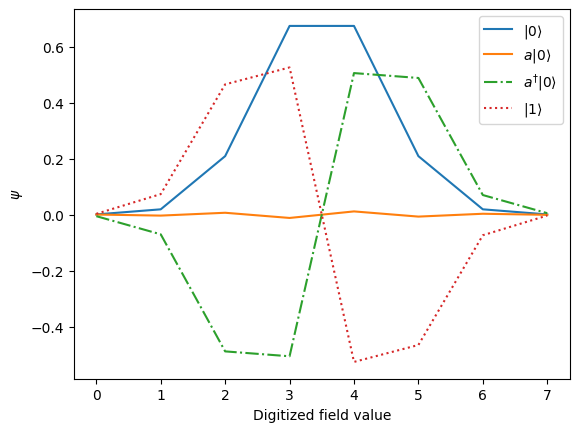

In [6]:
# Find lowest eigenstate ~ vacuum of SHO
# Define analogues of raising/lowering operators,
#   check that they approximately anihilate the vacuum + reproduce exited state

eigenvects = np.linalg.eig(SHOOp(Lat))[1].T
eigenvals = np.linalg.eig(SHOOp(Lat))[0]

#Be warned that the eigenvalues are not sorted by default (!)
eigenvects = [x for _,x in sorted(zip(eigenvals,eigenvects))]
eigenvals = np.sort(eigenvals)

vac = eigenvects[0]
maxE = Lat.EModes()[math.floor(Lat.nL/2)]
a_op = np.sqrt(maxE)/np.sqrt(2)*(phiOp(Lat) + 1/maxE * ipiOp(Lat))
adag_op = np.sqrt(maxE)/np.sqrt(2)*(phiOp(Lat) - 1/maxE * ipiOp(Lat))

plt.plot(np.real(vac),label=r"$|0\rangle$")
plt.plot(np.real(a_op @ vac),label=r"$a |0\rangle$")
plt.plot(np.real(adag_op @ vac),label=r"$a^\dag |0\rangle$",ls="-.")
plt.plot(np.real(eigenvects[1]),label=r"$|1\rangle$",ls=":") #only defined up to a sign so can be mirrored.
plt.legend()
plt.xlabel("Digitized field value")
plt.ylabel(r'$\psi$')

Text(0, 0.5, '$\\psi$')

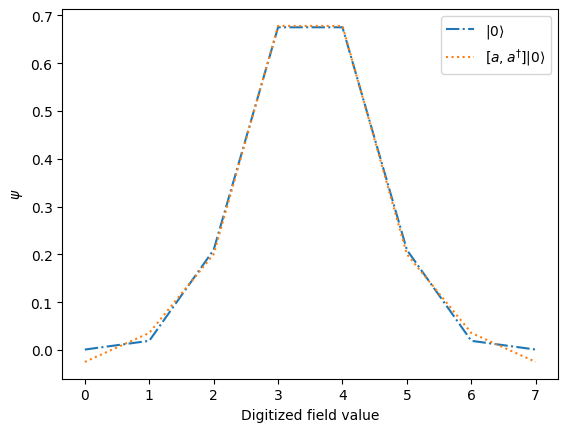

In [7]:
# A couple more checks
#  act on vacuum with [a, a^dag] ~ 1 + check accuracy of BCH reduction of coherent state

plt.plot(np.real(vac),label=r"$|0\rangle$",ls="-.")
plt.plot(np.real( (a_op @ adag_op - adag_op @ a_op) @ vac ),label=r"$[a,a^\dag] |0\rangle$",ls=":")
plt.legend()
plt.xlabel("Digitized field value")
plt.ylabel(r'$\psi$')

## Multi-site operators via Kronecker products

In [8]:
def operatorSite(opTup, posTup, lattice):
    """ Takes a tuple of operators and positions, and returns the Kronecker
        product of these on the specified lattice. Applies appropriate twist
        if operator position is outside the first Brouillin zone (0, nL-1).
        
        op is a tuple of functions of the form op(lattice) that are assumed to
        have already been defined. If this is not the case, the function will
        fail unexpectedly.
        
        pos is a tuple of positions, none of which can appear twice when
        projected to the first Bruillin zone, otherwise an exception is raised.
        
        !!! Has a known bug if the operator is itself a function of other
            operators, e.g., a Wilson line. The operators inside the function
            don't pick up required phases when moved back to the first BZ.
    """
    posList, phaseList = [], []
    for pos in posTup:
        wrapnum, posnum = divmod(pos, lattice.nL)
        phase = np.exp(1j*wrapnum*lattice.theta()).round(13)
        
        posList.append(posnum)
        phaseList.append(phase)
        
    if max([posList.count(x) for x in set(posList)]) > 1:
        raise Exception("More than one operator per lattice site!")
    
    opList = [idOp(lattice)] * lattice.nL
    
#    print(phaseList, posList)
        
    for op, pos, phase in zip(opTup, posList, phaseList):
        opList[pos] = phase*op

    fullOp = np.array([1])
    for op in opList:
        fullOp = np.kron(fullOp, op)
        
    return fullOp

## Hamiltonian

In [9]:
def HamiltonianPi(lattice):
    return lattice.dx * 0.5 * np.sum([operatorSite([pi2Op(lattice)], [i], lattice) for i in range(lattice.nL)], axis=0)

def HamiltonianPhi(lattice, lam=0):
    kinterm = -1./lattice.dx**2 * np.sum([operatorSite([phiOp(lattice),phiOp(lattice)],[i,i-1],lattice)
                                         + operatorSite([phiOp(lattice),phiOp(lattice)],[i,i+1],lattice)
                                         - 2*operatorSite([phi2Op(lattice)],[i],lattice) for i in range(lattice.nL)], axis=0)
    intterm = 0. if lam==0 else lam * np.sum([operatorSite([phi4Op(lattice)], [i], lattice) for i in range(lattice.nL)], axis=0)
    return lattice.dx * (0.5 * kinterm + (1/math.factorial(4)) * intterm)

def Hamiltonian(lattice, lam=0):
    ''' Create Hamiltonian for a massless scalar field theory.
        Optional quartic coupling can be set'''
    return HamiltonianPi(lattice) + HamiltonianPhi(lattice, lam)

In [10]:
myeigs = np.linalg.eig(Hamiltonian(Lat))
hamEigen = np.sort(np.absolute(myeigs[0]))

In [11]:
print('The first few eigvanlues:\n{}'.format(np.round(hamEigen[0:12],8)))

The first few eigvanlues:
[2.00007223 2.99958059 2.99958059 3.99927475 4.00123595 4.00123595
 4.00339598 4.99379346 4.99379346 4.99464398 5.00336403 5.00336403]


In [12]:
excitations = list(product(list(range(Lat.nPhi())), repeat=Lat.nL))
hamEigenExact = [sum([(0.5 + excitations[i][j])*Lat.EModes()[j] for j in range(Lat.nL)]) for i in range(len(excitations))]

excitations = [x for _,x in sorted(zip(hamEigenExact,excitations))]
hamEigenExact = np.sort(hamEigenExact)

In [13]:
for i in range(12):
    print("E = {:.2f} for state = {}".format(hamEigenExact[i], excitations[i]))

E = 2.00 for state = (0, 0, 0)
E = 3.00 for state = (1, 0, 0)
E = 3.00 for state = (0, 0, 1)
E = 4.00 for state = (0, 1, 0)
E = 4.00 for state = (2, 0, 0)
E = 4.00 for state = (1, 0, 1)
E = 4.00 for state = (0, 0, 2)
E = 5.00 for state = (1, 1, 0)
E = 5.00 for state = (2, 0, 1)
E = 5.00 for state = (3, 0, 0)
E = 5.00 for state = (0, 1, 1)
E = 5.00 for state = (0, 0, 3)


Text(0, 0.5, 'Fractional Error in Eigenvalue')

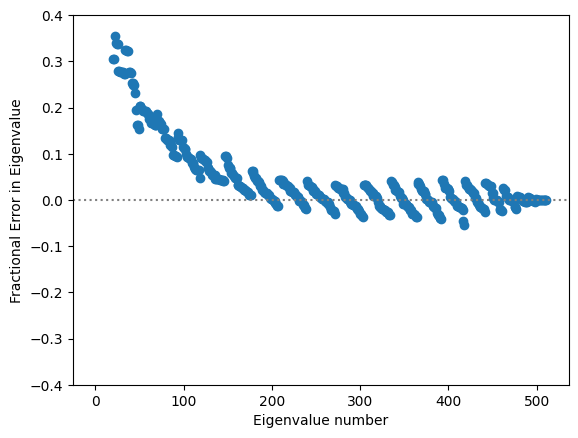

In [14]:
plt.plot((hamEigen[::-1]-hamEigenExact[::-1])/hamEigenExact[::-1],marker='o',ls="none")
plt.axhline(0,ls=":",color="grey")
plt.ylim([-0.4,0.4])
plt.xlabel("Eigenvalue number")
plt.ylabel("Fractional Error in Eigenvalue")

## Time evolution

In [15]:
def expHamiltonianPi(t, lattice):
    return scipy.linalg.expm(-1.j * t * HamiltonianPi(lattice))

def expHamiltonianPhi(t, lattice, lam=0):
    return scipy.linalg.expm(-1.j * t * HamiltonianPhi(lattice, lam))

def evolveH(t, lattice, lam=0):
    return scipy.linalg.expm(-1.j * t *Hamiltonian(lattice, lam))

def evolveHTrotter(t, n, lattice, lam=0):
    return np.linalg.matrix_power(expHamiltonianPi(t/n, lattice) @ expHamiltonianPhi(t/n, lattice, lam),n)

In [16]:
myeigs_trotter = np.linalg.eig(evolveHTrotter(1, 2000, Lat))
print("Lowest few eigenvalues of Trotterized H evolution: {}".format(np.sort(np.real(myeigs_trotter[0]))[0:10]))

Lowest few eigenvalues of Trotterized H evolution: [-0.99991184 -0.99906259 -0.99900198 -0.99844776 -0.99844776 -0.99562933
 -0.99529612 -0.99529612 -0.99522825 -0.99237334]


In [17]:
nsteps = 25
myvals = np.zeros([nsteps,Lat.nPhi()**Lat.nL])
for i in range(nsteps):
    myeigs_trotter = np.linalg.eig(evolveHTrotter(1,i+1, Lat))
    myvals[i,:] = np.sort(np.real(myeigs_trotter[0]))

## State preparation

In [19]:
def KitaevWebbDMDecomposition(input_mat):
    #https://arxiv.org/abs/0801.0342
    g = np.linalg.cholesky(input_mat)
    d = np.real(np.diag(np.diag(g)**2))
    l = np.real(g @ np.diag(np.diag(g)**-1))
    m = np.linalg.inv(l.conj().T)
    return d,m,g

matrixDim = 6
A = np.random.rand(matrixDim, matrixDim)
Cov = A @ A.T
print('The random matrix is\n {}'.format(Cov))

d,m,g = KitaevWebbDMDecomposition(Cov)

print('Put it back together\n {}'.format( np.linalg.inv(m.T) @ d @ np.linalg.inv(m) ))

The random matrix is
 [[1.89740268 1.57879078 1.28759117 2.07365367 1.41894761 1.8499816 ]
 [1.57879078 1.57058516 1.1160819  1.64894273 1.42425785 1.55309954]
 [1.28759117 1.1160819  1.49108147 1.12829341 1.04147261 1.20708001]
 [2.07365367 1.64894273 1.12829341 2.77272227 1.58233143 2.42000533]
 [1.41894761 1.42425785 1.04147261 1.58233143 1.64553666 1.72453182]
 [1.8499816  1.55309954 1.20708001 2.42000533 1.72453182 2.49615967]]
Put it back together
 [[1.89740268 1.57879078 1.28759117 2.07365367 1.41894761 1.8499816 ]
 [1.57879078 1.57058516 1.1160819  1.64894273 1.42425785 1.55309954]
 [1.28759117 1.1160819  1.49108147 1.12829341 1.04147261 1.20708001]
 [2.07365367 1.64894273 1.12829341 2.77272227 1.58233143 2.42000533]
 [1.41894761 1.42425785 1.04147261 1.58233143 1.64553666 1.72453182]
 [1.8499816  1.55309954 1.20708001 2.42000533 1.72453182 2.49615967]]


In [20]:
def GPhi(i, j, lattice, tol=13):
    x = lattice.xLattice()
    modeweight = lattice.EModes() * np.exp(1j*lattice.pLattice()*(x[i] - x[j]))
    return (1/lattice.nL)*np.sum(modeweight).round(tol)

def GPhiMatrix(lattice, tol=13):
    return [[GPhi(i,j, lattice) for j in range(lattice.nL)] for i in range(lattice.nL)]

In [21]:
def toPhiList(pos, lattice):
    return np.array([lattice.phiLattice()[int(gmpy2.digits(pos, lattice.nPhi()).zfill(lattice.nL)[i])] for i in range(lattice.nL)])

def KitaevWebbDMDecomposition(input_mat):
    #https://arxiv.org/abs/0801.0342
    g = np.linalg.cholesky(input_mat)
    d = np.real(np.diag(np.diag(g)**2))
    l = np.real(g @ np.diag(np.diag(g)**-1))
    m = np.linalg.inv(l.conj().T)
    return d,m,g

def createEigenstate(exlist, lattice):
    ''' Creates the normalized wavefunction for a digitized approximation
        of an energy eigenstate for a 1D lattice. 
          exlist: occupation numbers for momentum modes in the order given
                  by lattice.EModes(). [0, ..., 0] is the ground state
    '''
    if len(exlist) != lattice.nL:
        raise TypeError('Mode list incompatible with lattice size!')
    wavefun = np.zeros(lattice.nPhi()**lattice.nL, dtype=complex)
    x = lattice.xLattice()
    p = lattice.pLattice()
    phicov = GPhiMatrix(lattice)
    
    for i in range(lattice.nPhi()**lattice.nL):
        philist = toPhiList(i, lattice)
        expfactor = np.exp(-0.5 * philist @ phicov @ philist)
        
        terms = np.zeros(lattice.nL, dtype=complex)
        for n, nk in enumerate(exlist):
            Hcoeff = np.zeros(nk+1)
            Hcoeff[nk] = 1
            field = np.sqrt(lattice.EModes()[n]) * np.sqrt(1/lattice.nL)*np.sum([philist[i]*np.exp(-1j * p[n] * x[i]) for i in range(lattice.nL)])
            term = np.polynomial.hermite.hermval([field], Hcoeff).round(13)
            terms[n] = term
        wavefun[i] = expfactor * np.prod(terms)
    wavefun = wavefun/np.sqrt(np.sum(np.abs(wavefun)**2))
    return wavefun

def createKWground(lattice, ool_keep=True, decompose_shear=False):
    ''' Creates the KW approximationg of the scalar ground state for a given
        lattice, including proper treatment of shear matrices
            ool_keep: keep out-of-digitization-lattice entries by wrapping
                      to other side of lattice (dropping these would require
                      gabage collection on the quantum circuit) [True]
            decompose_shear: original KW procedure where every individual shift
                             is digitized before application [False]
    ''' 
    dcov,mshear,_ = KitaevWebbDMDecomposition(GPhiMatrix(lattice))
    invmshear = np.linalg.inv(mshear)

    ground = np.zeros(lattice.nPhi()**lattice.nL, dtype=complex)
    dphi = 2*lattice.phiMax/(lattice.nPhi()-1)
    
    for i in range(lattice.nPhi()**lattice.nL):
        philist = toPhiList(i, lattice)
        
        #Compute rotated field values after rounding to nearest digitized value
        philist = philist/dphi
        if decompose_shear:
            for j in range(len(invmshear)):
                shifts = np.rint((invmshear[j] * philist)[j+1:])
                philist[j] += np.sum(shifts)
            philist = np.rint(philist + lattice.phiMax/dphi)
        else:
            philist = invmshear @ philist
            philist = np.rint(philist + lattice.phiMax/dphi)

        #Two options for how to deal with out-of-lattice points
        if ool_keep:
            #Option A: wrap out-of-lattice point back to original lattce
            philist = np.mod(philist, lattice.nPhi())
            philist = philist*dphi - lattice.phiMax
        
            expfactor = np.exp(-0.5 * philist @ dcov @ philist)
        if not ool_keep:
            #Option B: just drop them (requires garbage collection in qcircuit)
            ool = any(id < -0.1 or id > lattice.nPhi() - 0.1 for id in philist)
            philist = philist*dphi - lattice.phiMax
        
            expfactor = np.exp(-0.5 * philist @ dcov @ philist) if not ool else 0.
            
        ground[i] = expfactor
            
    ground = ground/np.sqrt(np.sum(np.abs(ground)**2))
    return ground

def createKWstate(exlist, lattice):
    ''' !!! This method should be considered depreciated, as it does not yield
            a consistent state preparation on most lattices. To simulate what
            should be possible on an actual circuit, a combination of
            createKWground and action by adagop on the resulting state should
            be used.
        Creates the normalized wavefunction for the approximation
        of an energy eigenstate for a 1D lattice using the correlation
        of the Kitaev-Webb procedure.
        NB: Currently does not actually construct the KW state, since
        the shear matrix is not applied.
          exlist: occupation numbers for momentum modes in the order given
                  by lattice.EModes(). [0, ..., 0] is the ground state
    '''
    if len(exlist) != lattice.nL:
        raise TypeError('Mode list incompatible with lattice size!')
    wavefun = np.zeros(lattice.nPhi()**lattice.nL, dtype=complex)
    x = lattice.xLattice()
    p = lattice.pLattice()
    phicov = KitaevWebbDMDecomposition(GPhiMatrix(lattice))[0]
    
    for i in range(lattice.nPhi()**lattice.nL):
        philist = toPhiList(i, lattice)
        expfactor = np.exp(-0.5 * philist @ phicov @ philist)
        
        terms = np.zeros(lattice.nL, dtype=complex)
        for n, nk in enumerate(exlist):
            Hcoeff = np.zeros(nk+1)
            Hcoeff[nk] = 1
            field = np.sqrt(lattice.EModes()[n]) * np.sqrt(1/lattice.nL)*np.sum([philist[i]*np.exp(-1j * p[n] * x[i]) for i in range(lattice.nL)])
            term = np.polynomial.hermite.hermval([field], Hcoeff).round(13)
            terms[n] = term
        wavefun[i] = expfactor * np.prod(terms)
    wavefun = wavefun/np.sqrt(np.sum(np.abs(wavefun)**2))
    return wavefun

In [22]:
def aop(k, lattice):
    ''' Lowering operator for mode k of given lattice. '''
    x = lattice.xLattice()
    p = lattice.pLattice()
    # Hack to fix reversed indexing behavior relative to the direct state creation code that I don't understand
    k = lattice.nL - 1 - k
    
    pre = np.sqrt(lattice.EModes()[k]/(2*lattice.nL))
    phipiece = np.sum([operatorSite([phiOp(lattice)], [i], lattice)*np.exp(-1j * p[k] * x[i]) for i in range(lattice.nL)], axis=0)
    pipiece = np.sum([operatorSite([ipiOp(lattice)], [i], lattice)*np.exp(-1j * p[k] * x[i]) for i in range(lattice.nL)], axis=0)
    return pre * (phipiece + lattice.dx/lattice.EModes()[k] * pipiece)

def adagop(k, lattice):
    ''' Raising operator of mode k of given lattice. '''
    x = lattice.xLattice()
    p = lattice.pLattice()
    # Hack to fix reversed indexing behavior relative to the direct state creation code that I don't understand
    k = lattice.nL - 1 - k    
    
    pre = np.sqrt(lattice.EModes()[k]/(2*lattice.nL))
    phipiece = np.sum([operatorSite([phiOp(lattice)], [i], lattice)*np.exp(-1j * p[k] * x[i]) for i in range(lattice.nL)], axis=0)
    pipiece = np.sum([operatorSite([ipidagOp(lattice)], [i], lattice)*np.exp(-1j * p[k] * x[i]) for i in range(lattice.nL)], axis=0)
    return pre * (phipiece + lattice.dx/lattice.EModes()[k] * pipiece)

In [23]:
#Some plotting utils

def plot_persite(input_vals_list,nq_persite,nsites,labs):
    f = plt.figure(figsize=(5,5))
    
    forplot = np.zeros([nL*2**nQ,len(input_vals_list)])
    for k in range(len(input_vals_list)):
        for i in range(nL):
            for j in range(2**(nQ*nL)):
                qval = int(gmpy2.digits(j,2**nQ).zfill(nL)[i])
                forplot[qval+i*2**nQ,k]+=input_vals_list[k][j]
                pass
            pass
        pass
    
    print(forplot[:,0])
    
    xlabs = []
    for i in range(nL):
        plt.text(2**nQ*i+2**nQ/2-0.5,-0.4,"site "+str(i),horizontalalignment='center')
        if (i > 0):
            plt.axvline(2**nQ*i-0.5,color='grey',ls=":")
        for j in range(2**nQ):
            xlabs += [r'$|'+bin(j)[2:].zfill(nQ)+r'\rangle$']
            pass
        pass
    
    for k in range(len(input_vals_list)):
        plt.plot(forplot[:,k],label=labs[k])
        pass
    plt.ylabel("Pr(site)")
    plt.legend()
    
    plt.xticks(range(nsites*2**nq_persite),xlabs,rotation='vertical',fontsize=10,horizontalalignment='center')

In [24]:
LatHamEfun = np.linalg.eig(Hamiltonian(Lat))[1].T
LatHamEval = np.linalg.eig(Hamiltonian(Lat))[0]

LatHamEfun = [x for _,x in sorted(zip(LatHamEval,LatHamEfun), key=lambda x: x[0])]
LatHamEval = np.sort(LatHamEval)

[0.03675305 0.30683412 1.26249639 2.56077033 2.56077033 1.26249639
 0.30683412 0.03675305 0.03675305 0.30683412 1.26249639 2.56077033
 2.56077033 1.26249639 0.30683412 0.03675305 0.03675305 0.30683412
 1.26249639 2.56077033 2.56077033 1.26249639 0.30683412 0.03675305]


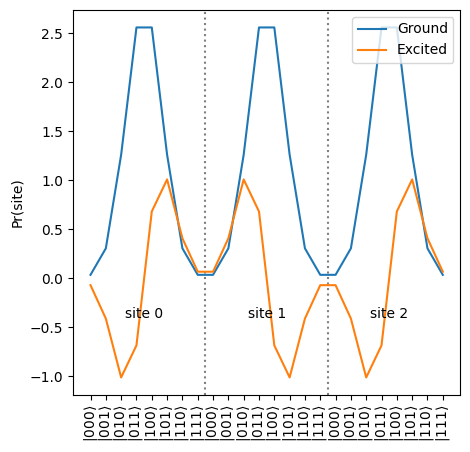

In [25]:
plot_persite([np.real(createEigenstate([0,0,0], Lat)), np.real(createEigenstate([0,1,0], Lat))],Lat.nQ,Lat.nL,labs=['Ground',"Excited"])

[0.03675305 0.30683412 1.26249639 2.56077033 2.56077033 1.26249639
 0.30683412 0.03675305 0.03675305 0.30683412 1.26249639 2.56077033
 2.56077033 1.26249639 0.30683412 0.03675305 0.03675305 0.30683412
 1.26249639 2.56077033 2.56077033 1.26249639 0.30683412 0.03675305]


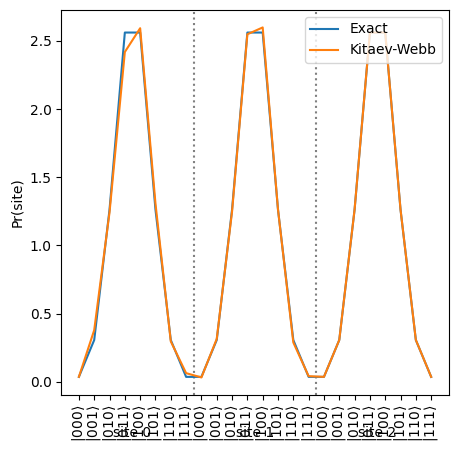

In [26]:
plot_persite([np.real(createEigenstate([0,0,0], Lat)),np.real(createKWground(Lat))],nQ,nL,labs=["Exact","Kitaev-Webb"])

### Qiskit cross check

In [27]:
# Basic initialization
%matplotlib inline
import math
import numpy as np
from scipy.linalg import cholesky
import matplotlib.gridspec as gridspec

import qiskit
from qiskit import Aer, execute
from qiskit import QuantumCircuit, QuantumRegister
import sys
import os

sys.path.append("/Users/bpnachman/Desktop/dl/lattice_qft")
print(sys.path)

from lattice_qft.core import lattice as lattice_cf
#from lattice_qft.core import settings
from lattice_qft.Scalar_Field_Theory import basic_operator_implementations as basic_op_cf
from lattice_qft.Scalar_Field_Theory import lattice_sft

import itertools

['/Users/bpnachman/Desktop/dl/lattice_qft/lattice_qft/examples', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python311.zip', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/lib-dynload', '', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/site-packages', '/Users/bpnachman/Desktop/dl/lattice_qft']
qiskit may not operate as intended because version 0.40.0 of qiskit is expected. Please install qiskit 0.40.0 instead of 0.43.1 which may is depreciated/appreciated.
['/Users/bpnachman/Desktop/dl/lattice_qft/lattice_qft/examples', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python311.zip', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/lib-dynload', '', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/site-packages', '/Users/bpnachman/Desktop/dl/lattice_qft']
good


In [28]:
simulator = Aer.get_backend('unitary_simulator')
simulator_state = Aer.get_backend('statevector_simulator')

In [29]:
# Define the lattice to be used
Lat.nQ = 2
dim = 1
num_ancilla = 1
lattice = lattice_sft.sft_lattice(dim, Lat.nL, Lat.dx, Lat.nQ, num_ancilla)

In [30]:
# Build ground state circuit

qc_ground = QuantumCircuit(lattice.get_q_register())
ground_state = lattice.ground_state(qc_ground, lattice.get_q_register())

In [31]:
result = execute(qc_ground, simulator_state).result()
statevector = result.get_statevector(qc_ground)

In [32]:
def qubit_vals(mycounts,nq_persite,nsites):
    #mycounts = result.get_counts()
    
    myout = np.zeros(nsites*2**nq_persite)
    for mysite in range(nsites):
        for i in range(2**nq_persite):
            for mystate in mycounts:
                if (mystate[nq_persite*mysite:nq_persite*(mysite+1)]==bin(i)[2:].zfill(nq_persite)):
                    myout[mysite*2**nq_persite+i]+=mycounts[mystate]
                    pass
                pass
            pass
        pass
    return myout

In [33]:
from lattice_qft.core.plot_utils import plot_persite_combined

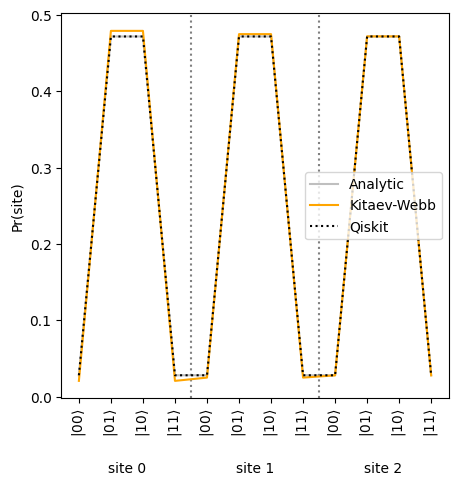

In [34]:
plot_persite_combined([abs(createEigenstate([0,0,0], Lat))**2,abs(createKWstate([0,0,0], Lat))**2,np.abs(statevector)**2],
                      Lat.nQ, Lat.nL, ["Analytic","Kitaev-Webb","Qiskit"], [False,False,True])

## Try evolving there and back again

In [35]:
#The basic operator phi^1 and pi^2
phi2 = basic_op_cf.Phi2Operator(lattice._phiMax)
print(lattice._phiMax)
pi2 = basic_op_cf.Pi2Operator(lattice._phiMax)

1.628102822756102


In [38]:
evolve_time, trotter_steps = 0.001, 1

qc_ground_nresets = QuantumCircuit(qc_ground.qubits)

for i in qc_ground.decompose():
    if i.operation.name != 'reset':
        qc_ground_nresets.append(i)
#print(qc_ground_nresets.decompose())

evolve_times = []
ground_state_prob = []
for evolve_time in np.logspace(-3,np.log(2)/np.log(10),20):
    evolve_H_Pi = QuantumCircuit(lattice.get_q_register())
    evolve_H_Phi = QuantumCircuit(lattice.get_q_register())
    t = evolve_time / trotter_steps
    for i in range(nL): #Assumes a 1d Lattice
        evolve_H_Pi.compose(lattice.apply_single_operator([[i], pi2, [t * 0.5]]),inplace=True)
        evolve_H_Phi.compose(lattice.apply_single_operator([[i], phi2, [t * 0.5 * 2 / dx**2]]), inplace=True)
        evolve_H_Phi.compose(lattice.apply_double_phi([i-1], [i], t * (-.5) / dx**2), inplace=True)
        evolve_H_Phi.compose(lattice.apply_double_phi([i+1], [i], t * (-.5) / dx**2), inplace=True)
    #print(qc_ground.draw())
    evolve_Trotter = QuantumCircuit(lattice.get_q_register())
    evolve_Trotter.compose(qc_ground, inplace=True)
    #print(evolve_Trotter)
    for i in range(trotter_steps):
        evolve_hamiltonian = evolve_H_Phi.compose(evolve_H_Pi, inplace=False)
        #print(evolve_hamiltonian)
        evolve_Trotter.compose(evolve_hamiltonian, inplace=True)
        #pass
    #print(qc_ground_nresets.decompose().decompose().decompose().decompose().decompose().draw())
    evolve_Trotter.compose(qc_ground_nresets.inverse(), inplace=True)
    result = execute(evolve_Trotter, simulator_state).result()
    statevector = result.get_statevector(evolve_Trotter)
    
    evolve_times += [evolve_time]
    ground_state_prob += [abs(statevector[0])**2]

1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.62810282

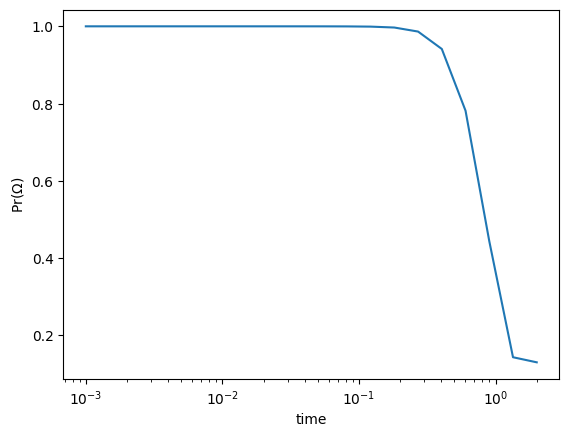

In [37]:
plt.plot(evolve_times,ground_state_prob)
plt.xlabel("time")
plt.ylabel("Pr($\Omega$)")
plt.xscale("log")